Versión que entrena el diccionario incluyendo la clase "Sin grupo"

## 1. Librerías y datasets

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import pickle

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from unicodedata import normalize

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_excel("Dicc_desde2021.xlsx")
x_train = train[["Titulo", "g"]]
test = pd.read_excel("PORTAL_1_2022_04.xlsx")
x_test = test.iloc[:,0]

<AxesSubplot:xlabel='g', ylabel='count'>

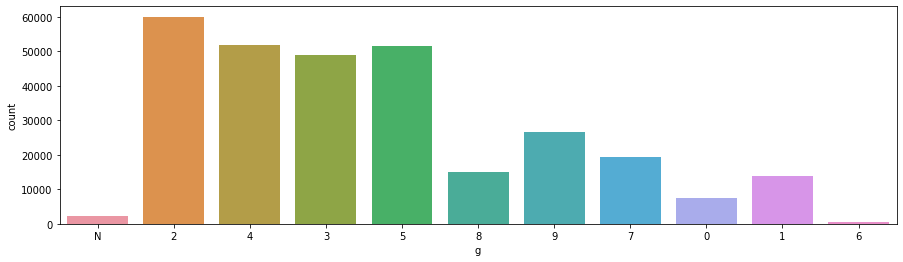

In [4]:
plt.figure(figsize=(15,4))
sns.countplot(x="g", data=x_train)

In [5]:
print("Porcentaje de missings:")
round(len(x_train[x_train["g"]=="N"])/len(x_train)*100, 2)

Porcentaje de missings:


0.74

In [6]:
x_train["g"] = np.where(x_train["g"]=="N", 10, x_train["g"])
x_train["g"] = x_train["g"].astype(int)

In [7]:
x_train["g"].value_counts()

2     60026
4     51729
5     51397
3     48954
9     26554
7     19312
8     15056
1     13749
0      7511
10     2209
6       445
Name: g, dtype: int64

## 2. Funciones y stopwords

In [8]:
# (1) Función que toma una lista con las palabras de una frase y elimina los stopwords

def drop_stopwords(string, stop_words_list):
    word_tokens = word_tokenize(string)
    frase = ""
    for i, word in enumerate(word_tokens):
        if not word in stop_words_list and i == 0 and word!="":
            frase = word
        elif word == "":
            continue
        elif not word in stop_words_list:
            frase = frase + " " + word
    return frase

In [9]:
# (2) Función que quita espacios al incio o al final

def quita_espacio(string):
    frase = ""
    tokenized = word_tokenize(string)
    for i, word in enumerate(tokenized):
        if i==0:
            frase = word
        else:
            frase = frase + " " + word
    return frase

In [10]:
# (3) Función que recibe una lista de texto y los normaliza

def limpia_texto(list_raw):

    list_text = [string.lower() for string in  list_raw]

    #puntuación. Se elimina toda la puntuacion excepto palabras y espacios. Se eliminan múltiples espacios.
    list_text = [re.sub(r'[^\w\s]', '', string) for string in list_text]
    list_text = [re.sub(' +', ' ', string) for string in list_text]

    #acentuación
    list_text = [re.sub(r'([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+', r'\1', 
                normalize( "NFD", string), 0, re.I) for string in list_text]

    #Remover números
    list_text = [re.sub(r'\d+', '', string) for string in list_text] #remoción de números
    list_text = [re.sub(' +', ' ', string) for string in list_text] #remoción de doble espaciado

    #Remover stopwords
    list_text = [drop_stopwords(string, stop_words3) for string in list_text]

    #Quita espacio
    list_text = [quita_espacio(string) for string in list_text]
    
    return list_text

In [16]:
#Stop words: stop words español + comunas + extras

stop_words = stopwords.words("spanish")

comuna = pd.read_excel("comunas.xlsx")

#obtención de comunas, provincias y regiones
provincias = comuna.provincia.unique().tolist()
regiones = comuna.region.unique().tolist()
comunas = comuna.comuna.tolist() + provincias + regiones

#acentuación y stopwords a comunas
comunas2 = [re.sub(r'([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+', r'\1', 
            normalize( "NFD", string.lower()), 0, re.I) for string in comunas]
comunas2 = [drop_stopwords(string, stop_words) for string in comunas2]

#se obtienen por separado los nombres de las comunas
new_stopwords = []
for komuna in comunas2:
    new_stopwords = new_stopwords + word_tokenize(komuna)
    
#se agrega a lista stop_words las comunas como palabras separadas
stop_words2 = stop_words + new_stopwords

extras= ['experiencia','rm','verano','invierno','otono','primavera','full','part', 'time','remplazo','reemplazo','hombre',
         'mujer','pm','am','sector','horas','as','turno','manana','tarde','noche','hombres','mujeres','lunes','martes',
         'miercoles','jueves','viernes','sabado','domingo','hrs', "norte", "sur", "centro", "a", "b", "c", "d", "e", "f", 
         "g", "h", "i", "l", "m", "n", "ñ", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", "diurno", "nocturno",
        "ii","iii","iv","v","vi","vii","viii","ix","x","xi","xii","xiii","xiv","xv","xvi"]

stop_words3 = stop_words2 + extras

## 3. Clasificación

In [18]:
x_train_final = limpia_texto(x_train["Titulo"].tolist())
x_test_final = limpia_texto(x_test.tolist())

In [19]:
x_train_final[:5]

['',
 'abogadoa contraloria universitaria',
 'abogadoa direccion juridica',
 'analista estudiosestadistica',
 'asistente bodega herramientas']

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [21]:
#TF-IDF

vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df=2)
x_train_tf = vectorizer.fit_transform(x_train_final)
x_test_tf = vectorizer.transform(x_test_final)

In [22]:
#Guardar vectorizer

#pkl_filename = "vector3.pkl"

#with open(pkl_filename, "wb") as file:
#    pickle.dump(vectorizer, file)

In [23]:
#def model_metrics(model, xtr, ytr, xtest, ytest):
#    mdl = model
#    mdl.fit(xtr, ytr)
#    y_pred = mdl.predict(xtest)
#    
#    acc = round(mdl.score(xtest, ytest), 2)
#    prec = round(precision_score(ytest, y_pred, average="macro"), 2)
#    rec = round(recall_score(ytest, y_pred, average="macro"), 2)
#
#    print("Accuracy: "+str(acc)+", precision: "+str(prec)+", recall: "+str(rec))

In [24]:
y_data = x_train["g"]

x_train, x_val, y_train, y_val = train_test_split(x_train_tf, y_data, test_size=0.2, random_state=12)

<AxesSubplot:xlabel='g', ylabel='count'>

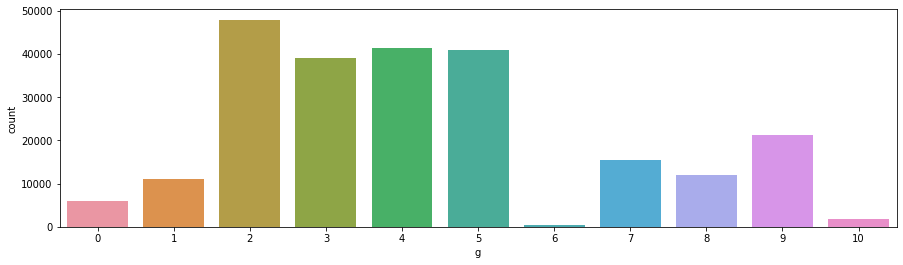

In [25]:
plt.figure(figsize=(15,4))
sns.countplot(x="g", data=pd.DataFrame(y_train)) #.sort_values("g"))

In [26]:
#model_metrics(RandomForestClassifier(), xtr=x_train, ytr=y_train, xtest=x_val, ytest=y_val)
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [34]:
cross_val_score(xgb, x_train, y_train, cv=3)

array([0.84110627, 0.8452844 , 0.84131895])

GridSearch

In [ ]:
params = { 'max_depth': [6,10],
           'learning_rate': [0.3, 0.4],
           'n_estimators': [100, 500],
           'colsample_bytree': [0.5, 0.7]}

xgbr = XGBClassifier(seed = 20)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='accuracy', 
                   verbose=1, cv=3)

clf.fit(x_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


#### Predicción test set

Se guarda el clasificador

In [27]:
#Se guarda el modelo
#import pickle

#pkl_filename = "rf3.pkl"

#with open(pkl_filename, "wb") as file:
#    pickle.dump(rf, file)

In [28]:
xgb.score(x_val, y_val)

0.8503426560474162

In [30]:
y_pred = xgb.predict(x_val)

In [31]:
round(precision_score(y_val, y_pred, average="macro"), 3)

0.878

In [32]:
round(f1_score(y_val, y_pred, average="macro"), 3)

0.851

In [33]:
round(recall_score(y_val, y_pred, average="macro"), 3)

0.833

In [101]:
confusion_matrix(y_val, y_pred)

array([[ 1416,     0,    25,    18,    11,    10,     0,     3,     0,
            0,     0],
       [    0,  2539,   101,    31,    35,    51,     1,     4,     0,
            4,     1],
       [    3,   131, 11220,   256,   171,   237,     1,    22,    16,
           21,     4],
       [    2,    47,   359,  8560,   369,   294,     0,    35,    23,
           68,     3],
       [   10,    32,   185,   172,  9266,   285,     1,   143,    70,
          137,     8],
       [    0,   106,   101,   141,   182,  9735,     1,    16,    38,
           88,    19],
       [    0,     1,     2,     2,     4,    15,    52,     1,     0,
            3,     1],
       [    0,     6,    49,   110,    88,   146,     0,  3303,    22,
           79,     3],
       [    0,     2,    21,    18,    24,    71,     0,    52,  2747,
           27,     0],
       [    0,     3,    33,    40,   121,   200,     1,    89,    33,
         4737,     9],
       [    0,     0,    10,     5,     7,    65,     0,    

Creación de dataframe

In [44]:
df_final = round(pd.DataFrame(y_pred_prob), 2)

df_final = pd.concat([pd.DataFrame(x_test_final).rename(columns={0:"descripcion"}), df_final], axis=1)

In [ ]:
#-------------------------------------

In [46]:
y_pred2 = rf.predict(x_test_tf)

In [47]:
df_final2 = round(pd.DataFrame(y_pred2), 2)

df_final2 = pd.concat([pd.DataFrame(x_test_final).rename(columns={0:"descripcion"}), df_final2], axis=1)

In [ ]:
#-------------------------------------

In [80]:
lista = []

for i in range(0,len(df_final)):
    if len(df_final.iloc[i,:][1:][df_final.iloc[i,:][1:]>=0.4]) > 0:
        lista = lista + [(df_final.iloc[i,:][1:][df_final.iloc[i,:][1:]>=0.4]).index[0]]
    else:
        lista = lista + [99]

In [81]:
df_final["grupo"] = lista

In [109]:
df_final2

,descripcion,0
0,practica profesional psicologia,0
1,asistente bodega,4
2,agente mesa ayuda,3
3,asistente alumnos tecnico secretariao,3
4,jefea refactoring decoupling rpa,2
...,...,...
25271,tecnicoa mecanicoa camiones,3
25272,coordinadora home delivery in house,8
25273,higienista prevencion,3
25274,ingeniero procesos,2


<AxesSubplot:xlabel='0', ylabel='count'>

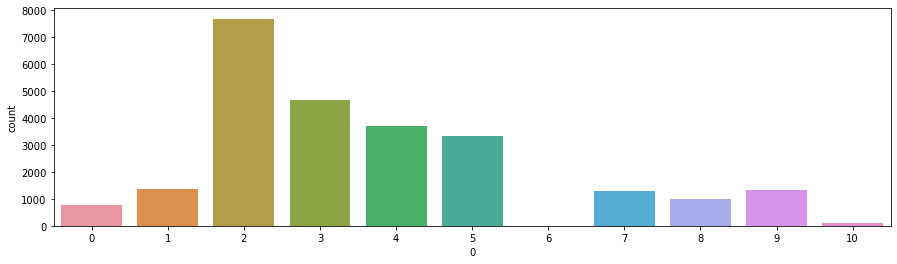

In [103]:
plt.figure(figsize=(15,4))
sns.countplot(x=0, data=df_final2)

In [106]:
# plt.figure(figsize=(15,4))
# sns.countplot(x="g", data=df_final)

In [110]:
print("porcentaje de no clasificados: "+str(round(len(df_final2[df_final2[0]==10])/len(df_final2)*100, 1)) + "%")

porcentaje de no clasificados: 0.4%


In [85]:
df_final[df_final["grupo"]==6]

,descripcion,0,1,2,3,4,5,6,7,8,9,grupo
2635,asistente agricola,0.0,0.02,0.00,0.05,0.20,0.02,0.71,0.00,0.00,0.00,6
7682,jardinero,0.0,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,6
7687,jardinero folio,0.0,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,6
8140,jardinero folio,0.0,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,6
15132,jardinero tractorista,0.0,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,6
16484,jardinero,0.0,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,6
16487,cod dcl trabajador agricola predio villucura,0.0,0.01,0.04,0.04,0.04,0.07,0.72,0.00,0.00,0.07,6
17770,jardinerola,0.0,0.00,0.05,0.05,0.06,0.07,0.69,0.03,0.02,0.03,6
21438,jardinero fr,0.0,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,6
22481,jardinero fijo dia,0.0,0.00,0.04,0.02,0.08,0.04,0.63,0.09,0.10,0.01,6


In [86]:
df_final[df_final["grupo"]==99]

,descripcion,0,1,2,3,4,5,6,7,8,9,grupo
332,houseman,0.00,0.01,0.17,0.15,0.18,0.22,0.01,0.10,0.05,0.11,99
422,operativo importaciones maritimas,0.00,0.01,0.13,0.11,0.21,0.19,0.00,0.27,0.04,0.04,99
535,suscriptor abierto ley,0.00,0.01,0.20,0.14,0.23,0.21,0.01,0.08,0.04,0.09,99
786,dispatcher,0.00,0.01,0.17,0.15,0.18,0.22,0.01,0.10,0.05,0.11,99
904,trainee industrial region,0.01,0.03,0.29,0.19,0.14,0.05,0.00,0.24,0.02,0.02,99
...,...,...,...,...,...,...,...,...,...,...,...,...
24879,asistentes cuentas pagar,0.01,0.00,0.12,0.33,0.39,0.10,0.00,0.00,0.01,0.04,99
24898,preparador muestras,0.00,0.00,0.06,0.22,0.34,0.16,0.00,0.08,0.08,0.06,99
24933,fonoaudiologaotemuco,0.00,0.01,0.17,0.15,0.18,0.22,0.01,0.10,0.05,0.11,99
25188,cod cx specialist,0.00,0.00,0.34,0.20,0.04,0.11,0.00,0.02,0.05,0.24,99


### Xgboost

### FastText